In [102]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from datetime import timedelta
from pathlib import Path

# ------------------------------------------------------------
# 1) Load and preprocess stocks_df, normalizing 'type' to only 'purchase' or 'sale'
#    — keep only transactions from 2020-01-01 to 2020-12-31
#    — exclude member_id "P000197"
# ------------------------------------------------------------
stocks_path = Path("../data/cleaned/2014-2023/stocks.csv")

stocks_df = pd.read_csv(
    stocks_path,
    parse_dates=["transaction_date"],
    usecols=["transaction_date", "sector", "type", "amount", "member_id"]
)

# Exclude the specified member_id
# stocks_df = stocks_df[~stocks_df["member_id"].isin(["P000197", "D000617","S001216"])].copy()

# Normalize the 'type' column and keep only "purchase" or "sale"
stocks_df["type"] = stocks_df["type"].str.lower()
stocks_df["type"] = stocks_df["type"].replace({"sale_partial": "sale", "sale_full": "sale"})
stocks_df = stocks_df[stocks_df["type"].isin(["purchase", "sale"])].copy()

# Filter to transactions between 2020-01-01 and 2020-12-31
start_date = pd.Timestamp("2019-01-01")
end_date   = pd.Timestamp("2022-12-31")
mask = (stocks_df["transaction_date"] >= start_date) & (stocks_df["transaction_date"] <= end_date)
stocks_df = stocks_df.loc[mask].reset_index(drop=True)

print("Preprocessed stocks_df shape:", stocks_df.shape)
stocks_df.head()


Preprocessed stocks_df shape: (15180, 5)


,transaction_date,type,amount,sector,member_id
0,2021-09-27,purchase,8000,Energy,F000450
1,2021-09-13,purchase,8000,Energy,F000450
2,2021-09-10,purchase,35000,Real Estate,F000450
3,2021-09-28,purchase,35000,Consumer Non-Durables,F000450
4,2021-09-17,sale,8000,Finance,L000579


In [103]:
from pathlib import Path
import pandas as pd

# -----------------------------------------------------------------------------
#  Step 1: Load both House and Senate vote summaries (2020–2021) into votes_full_df
# -----------------------------------------------------------------------------

all_dfs = []
base_folder = Path("../data/votes/summaries")

for chamber_folder in ["house", "senate"]:
    votes_folder = base_folder / chamber_folder 
    for year in range(2019, 2023):
        file_path = votes_folder / f"{year}.csv"
        if not file_path.exists():
            print(f"Error: {file_path} not found, skipping.")
            continue

        df = pd.read_csv(
            file_path,
            parse_dates=["vote_date"],
            dtype={
                "chamber": str,
                "congress": int,
                "session": int,
                "roll_number": int,
                "chamber_roll_number": int,
                "title": str,
                "question": str,
                "result": str,
                "yeas": int,
                "nays": int,
                "present": int,
                "not_voting": int,
            },
            usecols=[
                "chamber",
                "congress",
                "session",
                "roll_number",
                "chamber_roll_number",
                "vote_date",
                "title",
                "question",
                "result",
                "yeas",
                "nays",
                "present",
                "not_voting",
            ],
        )

        all_dfs.append(df)

# Concatenate into a single DataFrame
votes_full_df = pd.concat(all_dfs, ignore_index=True)

# Sort by vote_date
votes_full_df.sort_values("vote_date", inplace=True)
votes_full_df.reset_index(drop=True, inplace=True)

print("Loaded votes_full_df (House + Senate):", len(votes_full_df))
votes_full_df.head()


# -----------------------------------------------------------------------------
#  Step 2: Create bill_id on votes_full_df while chamber/congress/session are still present
# -----------------------------------------------------------------------------

votes_full_df["bill_id"] = (
    votes_full_df["chamber"].str.strip()
    + "_"
    + votes_full_df["congress"].astype(str)
    + "_"
    + votes_full_df["session"].astype(str)
    + "_"
    + votes_full_df["roll_number"].astype(str)
)

# Sanity check
assert votes_full_df["bill_id"].is_unique, "bill_id must be unique for each vote row."


# -----------------------------------------------------------------------------
#  Step 3: Filter to only those results you care about ("Passed" or "Bill Passed")
# -----------------------------------------------------------------------------

relevant_results = ["Passed", "Bill Passed"]

votes_filtered = votes_full_df[
    (votes_full_df["result"].isin(relevant_results)) &
    (votes_full_df["present"] == 0)
].copy()
votes_filtered.sort_values("vote_date", inplace=True)
votes_filtered.reset_index(drop=True, inplace=True)

print("Filtered votes (relevant results only):", len(votes_filtered))
votes_filtered.head()


# -----------------------------------------------------------------------------
#  Step 4: Shrink to only the columns needed downstream
# -----------------------------------------------------------------------------

votes_df = votes_filtered[
    ["bill_id", "vote_date", "title", "question", "result", "yeas", "nays", "present", "not_voting"]
].copy()

votes_df.head(10)


Loaded votes_full_df (House + Senate): 3621
Filtered votes (relevant results only): 1180


,bill_id,vote_date,title,question,result,yeas,nays,present,not_voting
0,House_116_1_3,2019-01-03,"Providing for consideration of H.Res. 6, adopt...",On Motion to Table the Motion to Refer,Passed,230,197,0,5
1,House_116_1_4,2019-01-03,"Providing for consideration of H.Res. 6, adopt...",On Ordering the Previous Question,Passed,233,197,0,2
2,House_116_1_6,2019-01-03,"Providing for consideration of H.Res. 6, adopt...",On Agreeing to the Resolution,Passed,234,194,0,4
3,House_116_1_7,2019-01-03,Adopting the Rules of the House of Representat...,On Agreeing to Title I of the Resolution,Passed,234,197,0,1
4,House_116_1_9,2019-01-03,Making further continuing appropriations for t...,On Passage,Passed,239,192,0,1
5,House_116_1_11,2019-01-03,Making appropriations for the fiscal year endi...,On Passage,Passed,241,190,0,2
6,House_116_1_12,2019-01-04,Adopting the Rules of the House of Representat...,On Agreeing to Title II of the Resolution,Passed,418,12,0,2
7,House_116_1_14,2019-01-08,Chemical Facility Anti-Terrorism Standards Pro...,On Motion to Suspend the Rules and Pass,Passed,414,3,0,16
8,House_116_1_13,2019-01-08,Pandemic and All-Hazards Preparedness and Adva...,On Motion to Suspend the Rules and Pass,Passed,401,17,0,15
9,House_116_1_16,2019-01-09,"Providing for consideration of H.R. 264, H.R. ...",On Ordering the Previous Question,Passed,231,195,0,7


In [104]:
B = nx.MultiGraph()
bill_nodes = set()
ticker_nodes = set()

for idx, vote_row in votes_df.iterrows():
    bill_id   = vote_row["bill_id"]
    vote_date = vote_row["vote_date"]
    window_start = vote_date - timedelta(days=3)
    window_end   = vote_date

    mask = (
        (stocks_df["transaction_date"] >= window_start) &
        (stocks_df["transaction_date"] <= window_end)
    )
    recent_tx = stocks_df.loc[mask, ["sector", "type", "amount"]]
    if recent_tx.empty:
        continue

    # Ensure the bill node exists
    if bill_id not in bill_nodes:
        B.add_node(bill_id, bipartite=1)
        bill_nodes.add(bill_id)

    # For each transaction row, add a separate edge
    for _, tx in recent_tx.iterrows():
        ticker = tx["sector"]
        tx_type = tx["type"]         # "purchase" or "sale"
        amount = tx["amount"]

        # Add ticker node if needed
        if ticker not in ticker_nodes:
            B.add_node(ticker, bipartite=0)
            ticker_nodes.add(ticker)

        # Add the MultiGraph edge with attributes
        B.add_edge(ticker, bill_id, weight=amount, tx_type=tx_type)

print(f"Built MultiGraph B: {len(bill_nodes)} bills, {len(ticker_nodes)} tickers, {B.number_of_edges()} edges")

Built MultiGraph B: 1168 bills, 20 tickers, 45787 edges


In [105]:
import networkx as nx

# -----------------------------------------------------------------------------
# 1) Compute weighted “degree” for each bill (i.e., sum of transaction amounts)
# -----------------------------------------------------------------------------
bill_weighted_amount = {
    bill: B.degree(bill, weight="weight")
    for bill in bill_nodes
}

# 2a) Degree centrality (unweighted, normalized)
deg_cent = nx.degree_centrality(B)

# 2d) Eigenvector centrality (use edge “weight”); convert MultiGraph to simple Graph
# so that parallel edges sum their weights. We create G_simple where each (u,v) has weight = sum of MultiGraph weights.
G_simple = nx.Graph()
for u, v, data in B.edges(data=True):
    w = data["weight"]
    if G_simple.has_edge(u, v):
        G_simple[u][v]["weight"] += w
    else:
        G_simple.add_edge(u, v, weight=w)

eig_cent = nx.eigenvector_centrality_numpy(G_simple, weight="weight")

# -----------------------------------------------------------------------------
# 3) Build weighted_df and attach these centrality measures for each bill
# -----------------------------------------------------------------------------

# 3a) Base DataFrame: bill_id → total_amount
weighted_df = (
    pd.DataFrame.from_dict(
        {
            "bill_id": list(bill_weighted_amount.keys()),
            "total_amount": list(bill_weighted_amount.values()),
        }
    )
    .sort_values("total_amount", ascending=False)
    .reset_index(drop=True)
)

# 3b) Merge in the human‐readable fields
weighted_df = weighted_df.merge(
    votes_df[["bill_id", "title", "vote_date", "result"]],
    on="bill_id",
    how="left"
)

# 3c) Add centrality columns for each bill
weighted_df["degree_centrality"] = weighted_df["bill_id"].map(deg_cent)
weighted_df["eigenvector_centrality"] = weighted_df["bill_id"].map(eig_cent)

# 4) Sort by total_amount (or any other column) and display
weighted_df = weighted_df.sort_values("degree_centrality", ascending=False).reset_index(drop=True)
weighted_df.head(25)


,bill_id,total_amount,title,vote_date,result,degree_centrality,eigenvector_centrality
0,Senate_116_2_76,7025000,H.R. 6201,2020-03-18,Bill Passed,0.330244,0.002104
1,House_116_2_227,9457000,National Apprenticeship Act,2020-11-20,Passed,0.191238,0.022784
2,House_116_1_426,2122000,Providing for consideration of the Senate amen...,2019-06-27,Passed,0.180286,0.001752
3,Senate_116_1_188,2122000,"S. 1790, As Amended",2019-06-27,Bill Passed,0.180286,0.001752
4,House_116_1_425,2122000,Providing for consideration of the Senate amen...,2019-06-27,Passed,0.180286,0.001752
5,House_116_1_428,2122000,SAFE Act,2019-06-27,Passed,0.180286,0.001752
6,House_116_1_429,2122000,Making emergency supplemental appropriations f...,2019-06-27,Passed,0.180286,0.001752
7,House_116_1_424,2106000,Making appropriations for financial services a...,2019-06-26,Passed,0.178602,0.001751
8,House_116_1_423,2106000,Making appropriations for financial services a...,2019-06-26,Passed,0.178602,0.001751
9,Senate_116_1_185,2106000,H.R. 3401 As Amended,2019-06-26,Bill Passed,0.178602,0.001751


Bill House_116_2_219 (vote_date = 2020-11-16): transactions from 2020-11-09 to 2020-11-16:
transaction_date                 sector     type  amount
      2020-11-12 Consumer Discretionary purchase   75000
      2020-11-12             Technology     sale    8000
      2020-11-12             Technology     sale   75000
      2020-11-12 Consumer Discretionary purchase   75000
      2020-11-12             Technology     sale   35000
      2020-11-12             Technology     sale   75000
      2020-11-13            Health Care purchase   75000
      2020-11-13                 Energy purchase   35000
      2020-11-16                 Energy purchase    8000
      2020-11-13            Health Care purchase   35000
      2020-11-13                 Energy purchase    8000
      2020-11-16                 Energy purchase    8000
      2020-11-13       Public Utilities purchase    8000
      2020-11-12             Technology purchase    8000
      2020-11-13                    NaN purchase    80

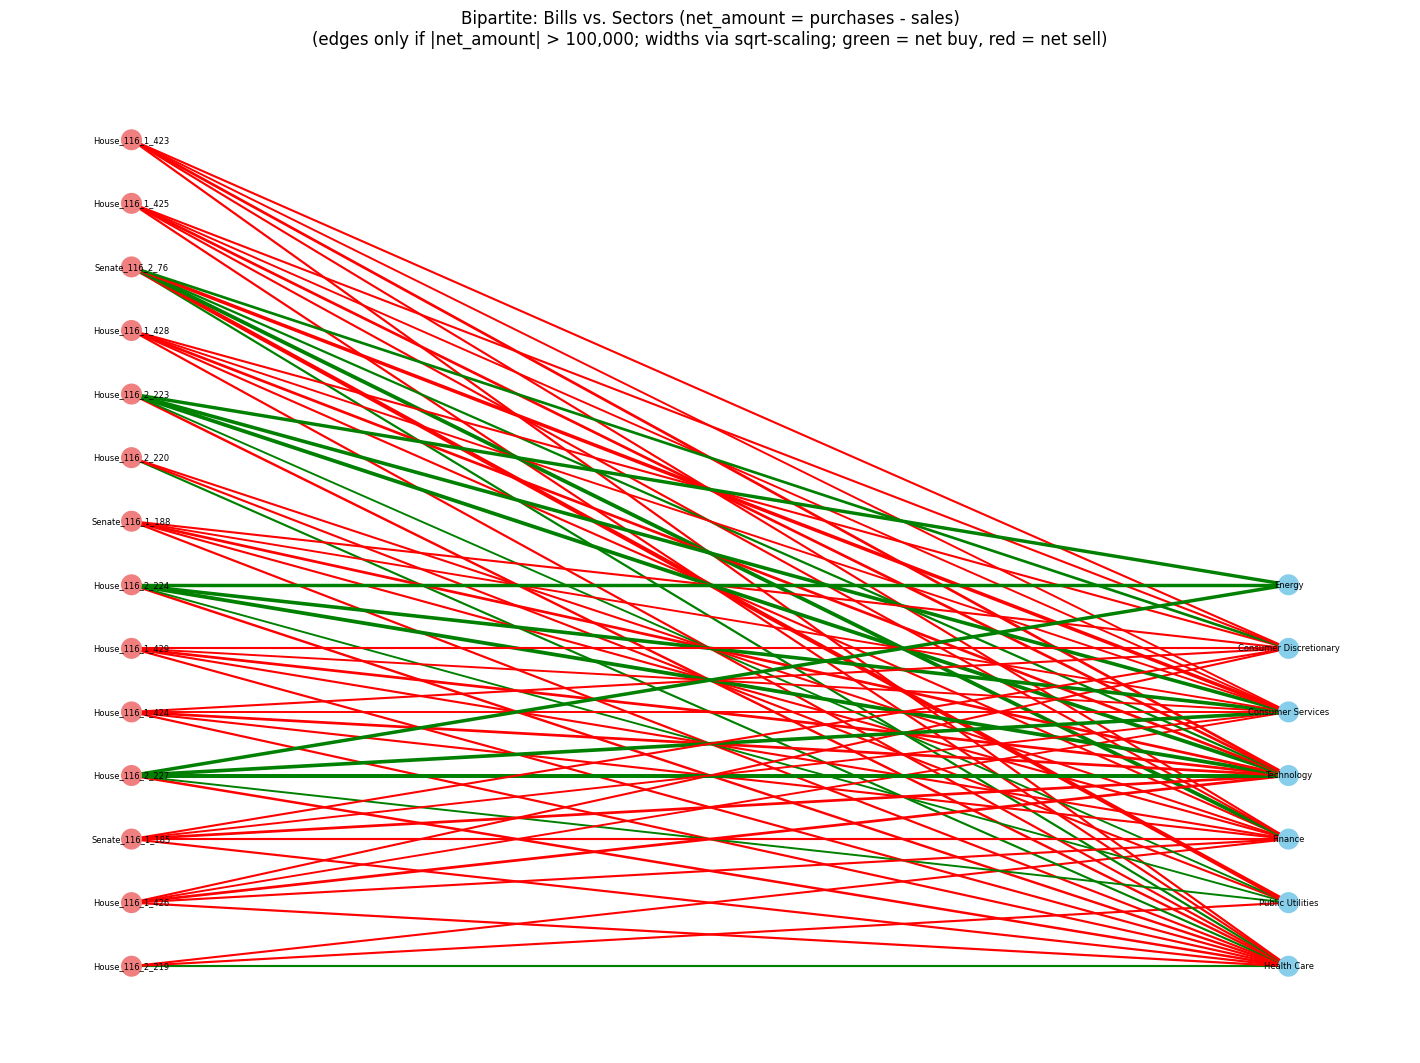

In [106]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------------------------------------------------
# Assume B is already built as a MultiGraph where:
#  - bill_nodes = set of bills (bipartite=1)
#  - ticker_nodes (actually sectors) = set of sectors (bipartite=0)
#  - each edge has attributes: weight (amount) and tx_type ("purchase"/"sale")
# votes_df contains ["bill_id", "vote_date", …]
# stocks_df contains ["transaction_date", "sector", "type", "amount"]
# -------------------------------------------------------------------

# Exclude these sectors entirely
exclude_sectors = {"Miscellaneous", "NaN"}

# -------------------------------------------------------------------
# 1) Compute total transaction amount for each bill:
bill_weighted_amount = {
    bill: B.degree(bill, weight="weight")
    for bill in bill_nodes
}

deg_cent = nx.degree_centrality(B)

threshold_amount = 2_000_000
threshold_deg = 0.13
bills_to_keep = {
    bill
    for bill in bill_nodes
    if (deg_cent.get(bill, 0) >= threshold_deg)
    and (bill_weighted_amount.get(bill, 0) >= threshold_amount)
}

# -------------------------------------------------------------------
# 2a) Print out all transactions for the bills we filtered
for bill_id in bills_to_keep:
    vote_date = votes_df.loc[votes_df["bill_id"] == bill_id, "vote_date"].iloc[0]
    window_start = vote_date - pd.Timedelta(days=7)
    window_end   = vote_date

    mask = (
        (stocks_df["transaction_date"] >= window_start) &
        (stocks_df["transaction_date"] <= window_end)
    )
    tx_for_bill = stocks_df.loc[mask, ["transaction_date", "sector", "type", "amount"]].copy()

    if tx_for_bill.empty:
        print(f"Bill {bill_id}: no transactions in window {window_start.date()} to {window_end.date()}\n")
        continue

    print(f"Bill {bill_id} (vote_date = {vote_date.date()}): transactions from {window_start.date()} to {window_end.date()}:")
    print(tx_for_bill.to_string(index=False))
    print("\n" + "-"*80 + "\n")

# -------------------------------------------------------------------
# 3) Build a simple Graph B_net where each edge (sector, bill) has:
#       net_amount = sum(purchases) - sum(sales)
#    Only include if |net_amount| > 100000, and skip excluded sectors/nan.
# -------------------------------------------------------------------
B_net = nx.Graph()

for bill_id in bills_to_keep:
    net_by_sector = {}
    for u, v, data in B.edges(bill_id, data=True):
        sector = u if v == bill_id else v
        if pd.isna(sector) or (sector in exclude_sectors):
            continue

        amt = data["weight"]
        if data["tx_type"] == "sale":
            amt = -amt

        net_by_sector[sector] = net_by_sector.get(sector, 0) + amt

    for sector, net_amt in net_by_sector.items():
        # Only draw edge if |net_amt| > 100,000
        if abs(net_amt) <= 100_000:
            continue

        B_net.add_node(bill_id, bipartite=1)
        B_net.add_node(sector, bipartite=0)
        B_net.add_edge(sector, bill_id, net_amount=net_amt)

# -------------------------------------------------------------------
# 4) Summarize B_net
print(
    f"B_net stats:\n"
    f"  • # of bill nodes: {sum(d['bipartite'] == 1 for _, d in B_net.nodes(data=True))}\n"
    f"  • # of sector nodes: {sum(d['bipartite'] == 0 for _, d in B_net.nodes(data=True))}\n"
    f"  • # of edges: {B_net.number_of_edges()}"
)

# -------------------------------------------------------------------
# 5) Extract two node sets for plotting
bills_left    = [n for n, d in B_net.nodes(data=True) if d["bipartite"] == 1]
sectors_right = [n for n, d in B_net.nodes(data=True) if d["bipartite"] == 0]

# -------------------------------------------------------------------
# 6) Assign positions: bills at x=0, sectors at x=1
pos = {}
pos.update((bill,   (0, i)) for i, bill   in enumerate(bills_left))
pos.update((sector,(1, i)) for i, sector in enumerate(sectors_right))

# -------------------------------------------------------------------
# 7) Better scaling: use square‐root mapping for edge widths
all_net = [data["net_amount"] for _, _, data in B_net.edges(data=True)]
if all_net:
    max_net = max(abs(x) for x in all_net)
    max_width = 3.0
    min_width = 0.5
    sqrt_max = max_net ** 0.5
else:
    sqrt_max = 1.0
    max_width = 3.0
    min_width = 0.5

# -------------------------------------------------------------------
# 8) Prepare lists of edge colors and widths for B_net
edge_colors = []
edge_widths = []

for u, v, data in B_net.edges(data=True):
    net_amt = data["net_amount"]
    color = "green" if net_amt > 0 else "red"
    edge_colors.append(color)

    abs_sqrt = abs(net_amt) ** 0.5
    width = min_width + (abs_sqrt / sqrt_max) * (max_width - min_width)
    edge_widths.append(width)

# -------------------------------------------------------------------
# 9) Draw the final bipartite graph
plt.figure(figsize=(14, 10))
nx.draw(
    B_net,
    pos=pos,
    with_labels=True,
    node_size=200,
    node_color=[
        "lightcoral" if B_net.nodes[n]["bipartite"] == 1 else "skyblue"
        for n in B_net.nodes()
    ],
    font_size=6,
    edge_color=edge_colors,
    width=edge_widths
)
plt.title(
    "Bipartite: Bills vs. Sectors (net_amount = purchases - sales)\n"
    "(edges only if |net_amount| > 100,000; widths via sqrt-scaling; green = net buy, red = net sell)"
)
plt.axis("off")
plt.savefig("../results/images/bills_sectors_graph.png", dpi=300, bbox_inches="tight")
